In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv
import graphviz

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, make_scorer, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.cluster import KMeans, AgglomerativeClustering

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
%%time
data_train = pd.read_csv('./Matrices/sample_data_train.csv')
data_test = pd.read_csv('./Matrices/sample_data_test.csv')
data = pd.concat([data_train, data_test], ignore_index=True)
data = data.sample(5000)

del data_train, data_test

Wall time: 570 ms


In [3]:
def run_agglomerative(data, vects):
    sc = StandardScaler()
    
    data_np = data.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    data_np = np.hstack((data_np, vects))
    data_np = sc.fit_transform(data_np)
    
    scores = []; clusters = [2, 3, 5, 7, 10];
    for i in clusters:
        print(f'Starting Cluster #{i}')
        model = AgglomerativeClustering(n_clusters=i)
        model.fit(data_np)
        score = silhouette_score(data_np, model.labels_, random_state=42)
        scores.append(score)

    plt.plot(clusters, scores)
    plt.xlabel('Clusters')
    plt.ylabel('Silhoutte Score')
    plt.show()
    
    return data_np

# BOW based Agglomerative Clustering

In [4]:
%%time
cv_model = CountVectorizer(max_features=1000, min_df=10)
bow_counts = cv_model.fit_transform(data['CleanedText'].values)
print(bow_counts.shape)

(5000, 1000)
Wall time: 224 ms


Starting Cluster #2
Starting Cluster #3
Starting Cluster #5
Starting Cluster #7
Starting Cluster #10


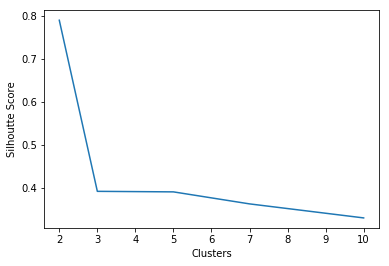

Wall time: 1min 36s


In [5]:
%%time
data_np = run_agglomerative(data, bow_counts.toarray())

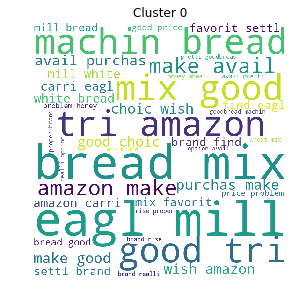

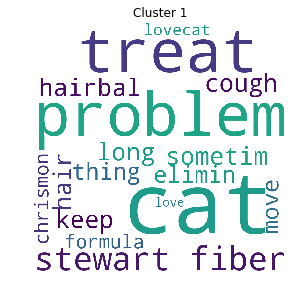

Wall time: 23.7 s


In [6]:
%%time
model = AgglomerativeClustering(n_clusters=2)
model.fit(data_np)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

# TFIDF based Agglomerative Clustering

In [7]:
%%time
tfidf_model = TfidfVectorizer(max_features=1000, min_df=10)
vectors = tfidf_model.fit_transform(data['CleanedText'].values)
print(vectors.shape)

(5000, 1000)
Wall time: 286 ms


Starting Cluster #2
Starting Cluster #3
Starting Cluster #5
Starting Cluster #7
Starting Cluster #10


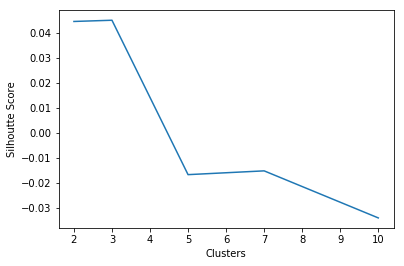

Wall time: 1min 37s


In [8]:
%%time
data_np = run_agglomerative(data, vectors.toarray())

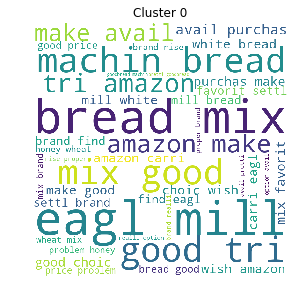

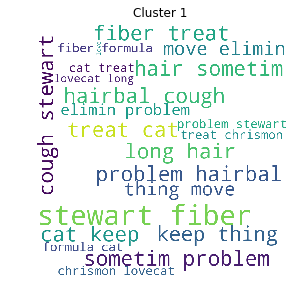

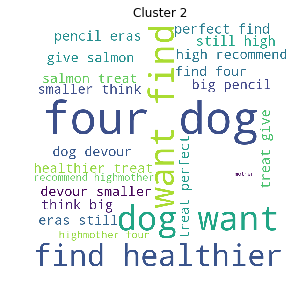

Wall time: 24.4 s


In [9]:
%%time
model = AgglomerativeClustering(n_clusters=3)
model.fit(data_np)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']

for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

# Avg. W2V based Agglomerative Clustering

In [6]:
%%time
def avg_w2v(data_train):
    train_list_of_sent=[]
    for sent in data_train['CleanedText'].values:
        train_list_of_sent.append(sent.split())

    w2v_model = Word2Vec(train_list_of_sent, min_count=5, size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    sent_vectors_train = []
    for sent in train_list_of_sent:
        sent_vec = np.zeros(50)
        count_words = 0
        for word in sent:
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]
                except KeyError:
                    vec = np.zeros(50)
                sent_vec += vec
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors_train.append(sent_vec)
    
    return sent_vectors_train

vectors = avg_w2v(data)

Wall time: 4.26 s


Starting Cluster #2
Starting Cluster #3
Starting Cluster #5
Starting Cluster #7
Starting Cluster #10


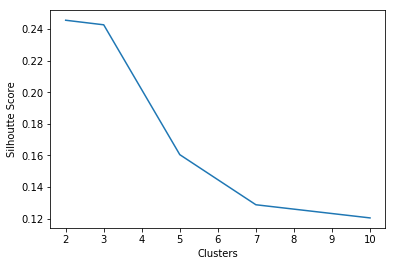

Wall time: 10.9 s


In [7]:
%%time
data_np = run_agglomerative(data, vectors)

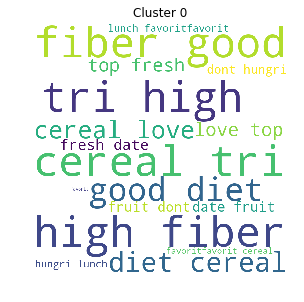

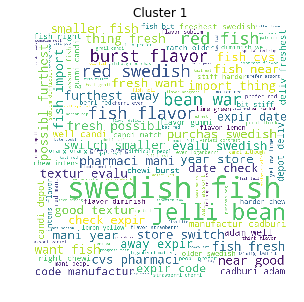

Wall time: 7.05 s


In [8]:
%%time
model = AgglomerativeClustering(n_clusters=2)
model.fit(data_np)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']

for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

# TFIDF-weighted W2V based Agglomerative Clustering

In [10]:
%%time
def tfidf_w2v(data_train):
    tfidf = TfidfVectorizer()
    tfidf_vect_train = tfidf.fit_transform(data_train['CleanedText'].values).toarray()
    words_dict = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

    list_of_sent=[]
    for sent in data_train['CleanedText'].values:
        list_of_sent.append(sent.split())
    
    w2v_model = Word2Vec(list_of_sent, min_count=5, size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    tfidf_sent_vectors_train = []
    row=0
    for sent in list_of_sent:
        sent_vec = np.zeros(50)
        weighted_sum = 0
        for word in sent:
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]
                except KeyError:
                    vec = np.ones(50)
                try:
                    tf_idf = words_dict[word]*(sent.count(word)/len(sent))
                except KeyError:
                    tf_idf = 1.0*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weighted_sum += tf_idf
        if weighted_sum != 0:
            sent_vec /= weighted_sum
        tfidf_sent_vectors_train.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors_train

vectors = tfidf_w2v(data)

Wall time: 4.7 s


Starting Cluster #2
Starting Cluster #3
Starting Cluster #5
Starting Cluster #7
Starting Cluster #10


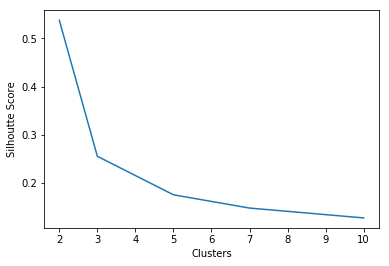

Wall time: 10.3 s


In [11]:
%%time
data_np = run_agglomerative(data, vectors)

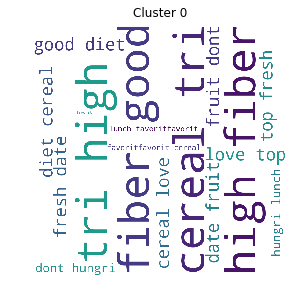

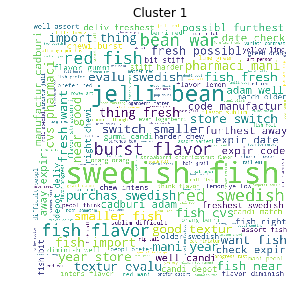

Wall time: 6.64 s


In [12]:
%%time
model = AgglomerativeClustering(n_clusters=2)
model.fit(data_np)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']

for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## Summary :-
- The Dataset is imported and various Vectorizer models are trained on the pre-processed Amazon Food Reviews.
- The data is then Standardized and fed to Agglomerative Clustering with a number of 'n_clusters' values.
- The Optimal 'n_clusters' is evaluated using the Elbow method on 'No. of Clusters' vs 'Silhoutte Score' and a final Clustering is performed using the optimal value.
- Cluster Sets are evaluated such that each cluster number contains all the words from all Reviews in that Cluster.
- Word Cloud is used to highlight the words present in each of the Clusters.